# Water balance plots

This sheet checks and documents the water balance for ATS simulations based on models such as "priestly_taylor_canopy_evapotranspiration" that include four water pools -- canopy, snow, surface water, and subsurface water.  We can verify each of these independently.

Note all of these are done in units of [m] or [m/s], which means dividing by surface area or molar density as required to convert to these units.

**Global water balance**

First look at the global balance.  The global balance is given by:

$$dWC/dt = P + S - ET - Q$$

where:

- WC: total global water content across all four pools (surface, canopy, snow, and subsurface; converted from mol --> m)
- P: precip of rain
- S: precip of snow
- ET: total evapotranspiration across all four pools (canopy evaporation, snow sublimation/condensation, surface water evaporation, and transpiration)
- Q: surface water runoff

**Snow water balance**

Next lets verify each individual component.  First we look at snow.

Snow mass balance is given by:

$$dWC_{snow}/dt = S_{throughfall} + S_{drippage} - E_{snow} - SM$$

where:

- WC_snow: snow water content
- S_throughfall: portion of snow precip that misses the canopy and lands on the snowpack
- S_drippage: portion of snow that drops from the canopy
- E_snow: snow sublimation (positive) or condensation (negative)
- SM: snow melt

**Canopy water balance**

$$dWC_{can}/dt = S_{interception} + P_{interception} - D - E_{can}$$

where:

- WC_can: canopy water content
- I: interception of rain and snow
- D: drainage and dripping from the canopy
- E_can: leaf canopy water evaporation

**Surface water balance**

$$dWC_{surf}/dt = P_{throughfall} + D_{rain} + SM - E - Q - I$$

where:

- WC_surf: surface water content
- P_throughfall: throughfall of rain
- D_rain: canopy drainage of rain
- SM: snowmelt
- E: surface water/bare ground evaporation
- Q: runoff/discharge (converted to m/s)
- I: infiltration (water infiltrates into the subsurface, i.e. leaving surface)

**Subsurface water balance**

Lastly the subsurface is fairly simple because we closed all the boundaries except the surface:

$$dWC_{sub}/dt = I - T$$

Where:

- WC_sub: subsurface water content
- I: infiltration
- T: transpiration



In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

%load_ext autoreload
%autoreload 2

In [4]:
import os, re, glob
import numpy as np, pandas as pd
import h5py
import matplotlib.pyplot as plt

import modvis.ATSutils as utils
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s: %(message)s')

In [5]:
# run_steadystate = "1-spinup_steadystate"
work_dir = f"../../model2/"

rho_m = 55500 # moles/m^3, water molar density. Check this in the xml input file.

## plot spinup-steadystate

In [6]:
run_dir = "1-spinup_steadystate"
model_dir = os.path.join(work_dir, run_dir)
logging.info(f"Loading data from {model_dir}")

2025-04-27 22:26:49,920 - root - INFO: Loading data from ../../model2/1-spinup_steadystate


In [7]:
df = pd.read_csv(os.path.join(model_dir, 'water_balance.dat'), comment='#')

# df['time [d]'] = df['time [s]']/86400
df.set_index('time [d]', inplace = True)

# df['outlet flux [m^3/s]'] = df['surface outlet flux [mol/s]']/ rho_m
# df['subsurface water content [m^3]'] = df['total water content [mol]']/ rho_m
df['outlet flux [m^3/d]'] = df['net runoff [mol d^-1]']/ rho_m
df['total water content [m^3]'] = (df['surface water content [mol]'] + df['subsurface water content [mol]'])/ rho_m

df

,net runoff [mol d^-1],surface water content [mol],subsurface water content [mol],max ponded depth [m],outlet flux [m^3/d],total water content [m^3]
time [d],,,,,,
0.000000,0.000000e+00,0.000000e+00,2.188413e+13,0.000000,0.000000,3.943086e+08
0.000058,0.000000e+00,0.000000e+00,2.188413e+13,0.000000,0.000000,3.943086e+08
0.000116,0.000000e+00,0.000000e+00,2.188413e+13,0.000000,0.000000,3.943086e+08
0.000174,0.000000e+00,0.000000e+00,2.188413e+13,0.000000,0.000000,3.943086e+08
0.000246,0.000000e+00,0.000000e+00,2.188413e+13,0.000000,0.000000,3.943087e+08
...,...,...,...,...,...,...
3643.678860,1.935647e+10,2.014969e+13,2.193287e+13,38.053473,348765.305481,7.582444e+08
3645.363122,1.935639e+10,2.014973e+13,2.193287e+13,38.053475,348763.771691,7.582452e+08
3647.047384,1.935630e+10,2.014978e+13,2.193287e+13,38.053476,348762.237900,7.582460e+08


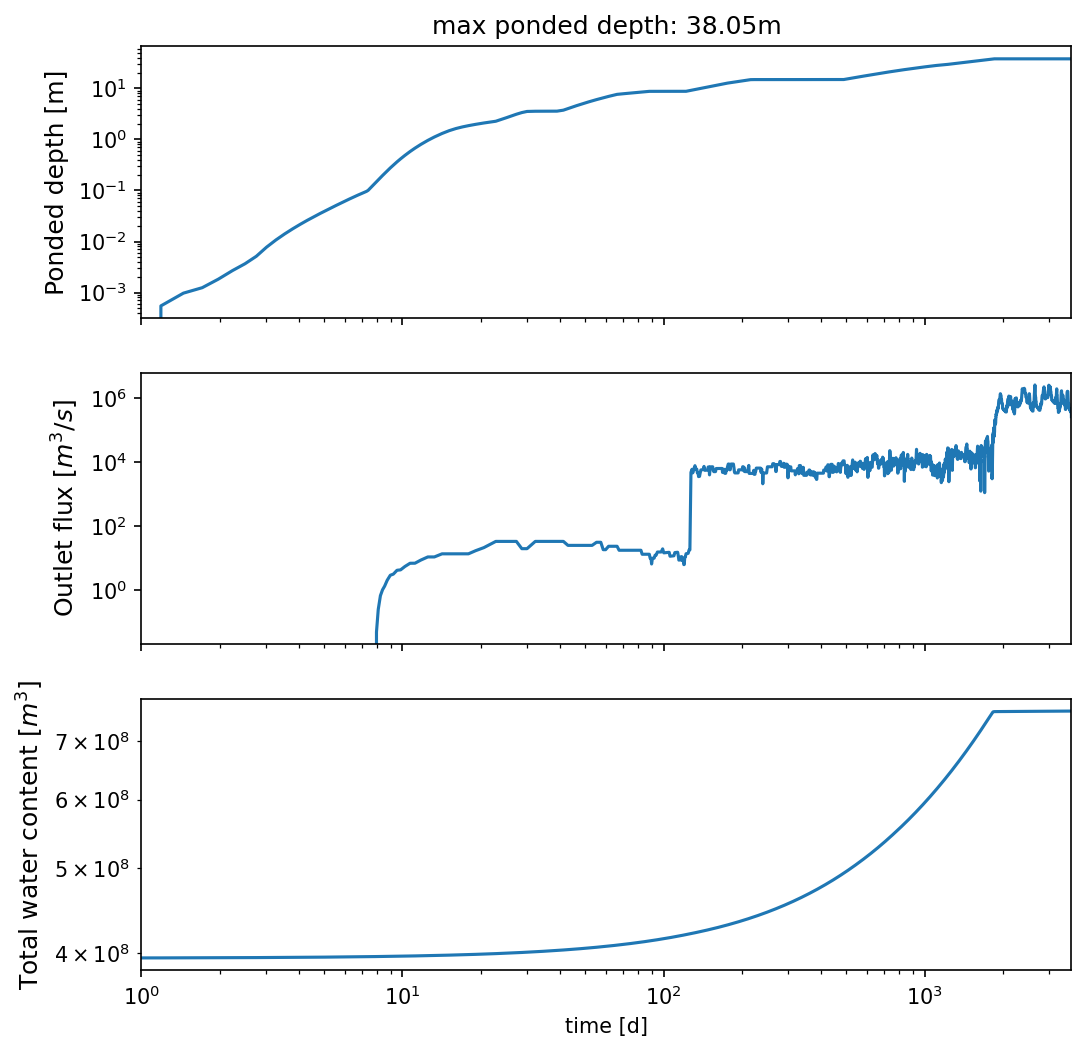

In [8]:
fig, axes = plt.subplots(3,1, figsize=(8, 8), sharex = True)
fontsize = 12
xlim = [1, df.index[-1]]

ax = axes[0]
df.plot( y='max ponded depth [m]', ax = ax)
ax.set_xlim(xlim)
ax.set_title(f"max ponded depth: {df['max ponded depth [m]'].max():.2f}m")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Ponded depth [m]', fontsize = fontsize)
ax.get_legend().remove()
ax = axes[1]
df.plot( y='outlet flux [m^3/d]', ax = ax)
ax.set_xlim(xlim)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Outlet flux [$m^3/s$]', fontsize = fontsize)
ax.get_legend().remove()
ax = axes[2]
df.plot( y='total water content [m^3]', ax = ax)
ax.set_xlim(xlim)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Total water content [$m^3$]', fontsize = fontsize)
ax.get_legend().remove()

## plot spinup-cyclic

In [9]:
run_dir = "2-spinup_cyclic"
model_dir = os.path.join(work_dir, run_dir)
logging.info(f"Loading data from {model_dir}")

2025-04-27 22:26:53,092 - root - INFO: Loading data from ../../model2/2-spinup_cyclic


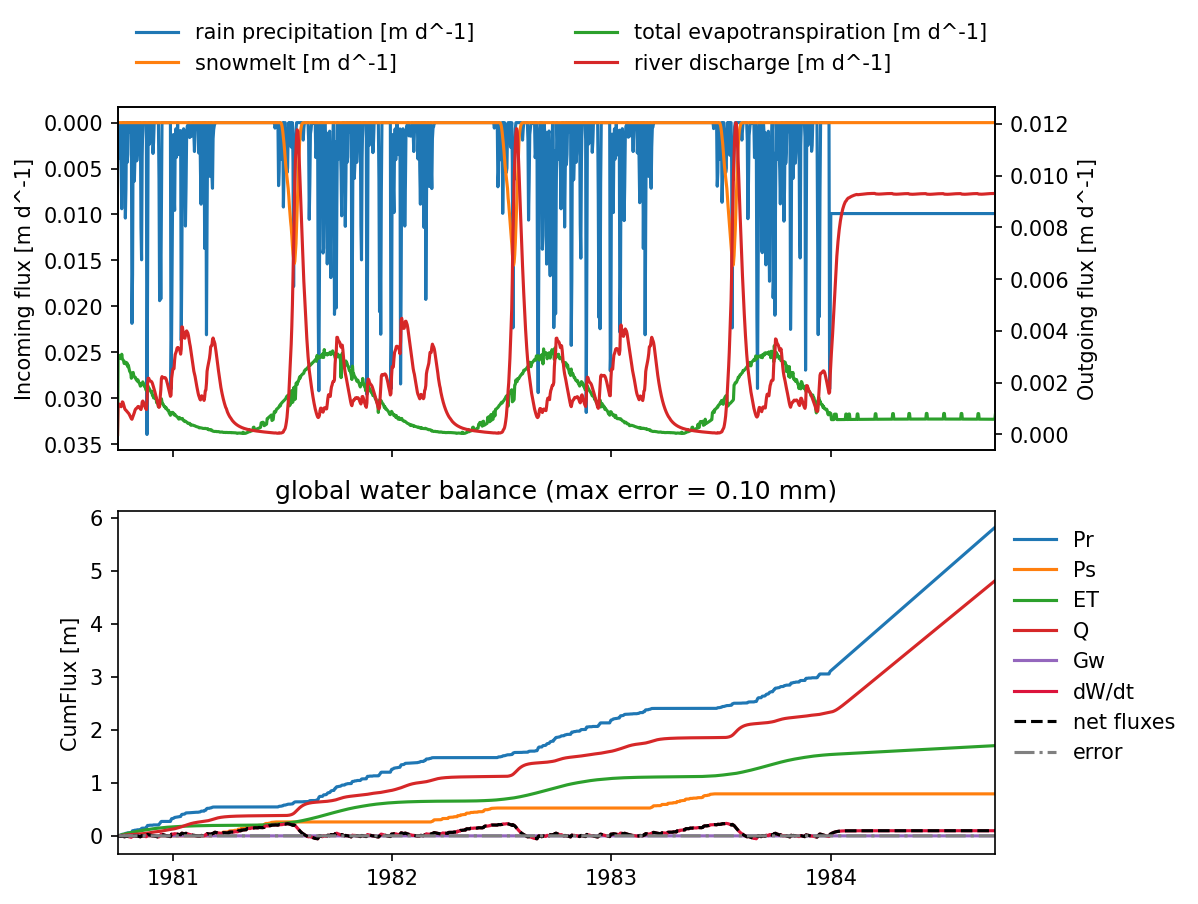

In [10]:
df = utils.load_waterBalance(model_dir, WB_filename="water_balance_computational_domain.csv",
                             domain_names = ['global'],
                                canopy = True, plot = True
                               )

## plot transient

In [13]:
run_dir = "3-transient"
model_dir = os.path.join(work_dir, run_dir)
logging.info(f"Loading data from {model_dir}")

2025-04-27 22:27:30,072 - root - INFO: Loading data from ../../model2/3-transient


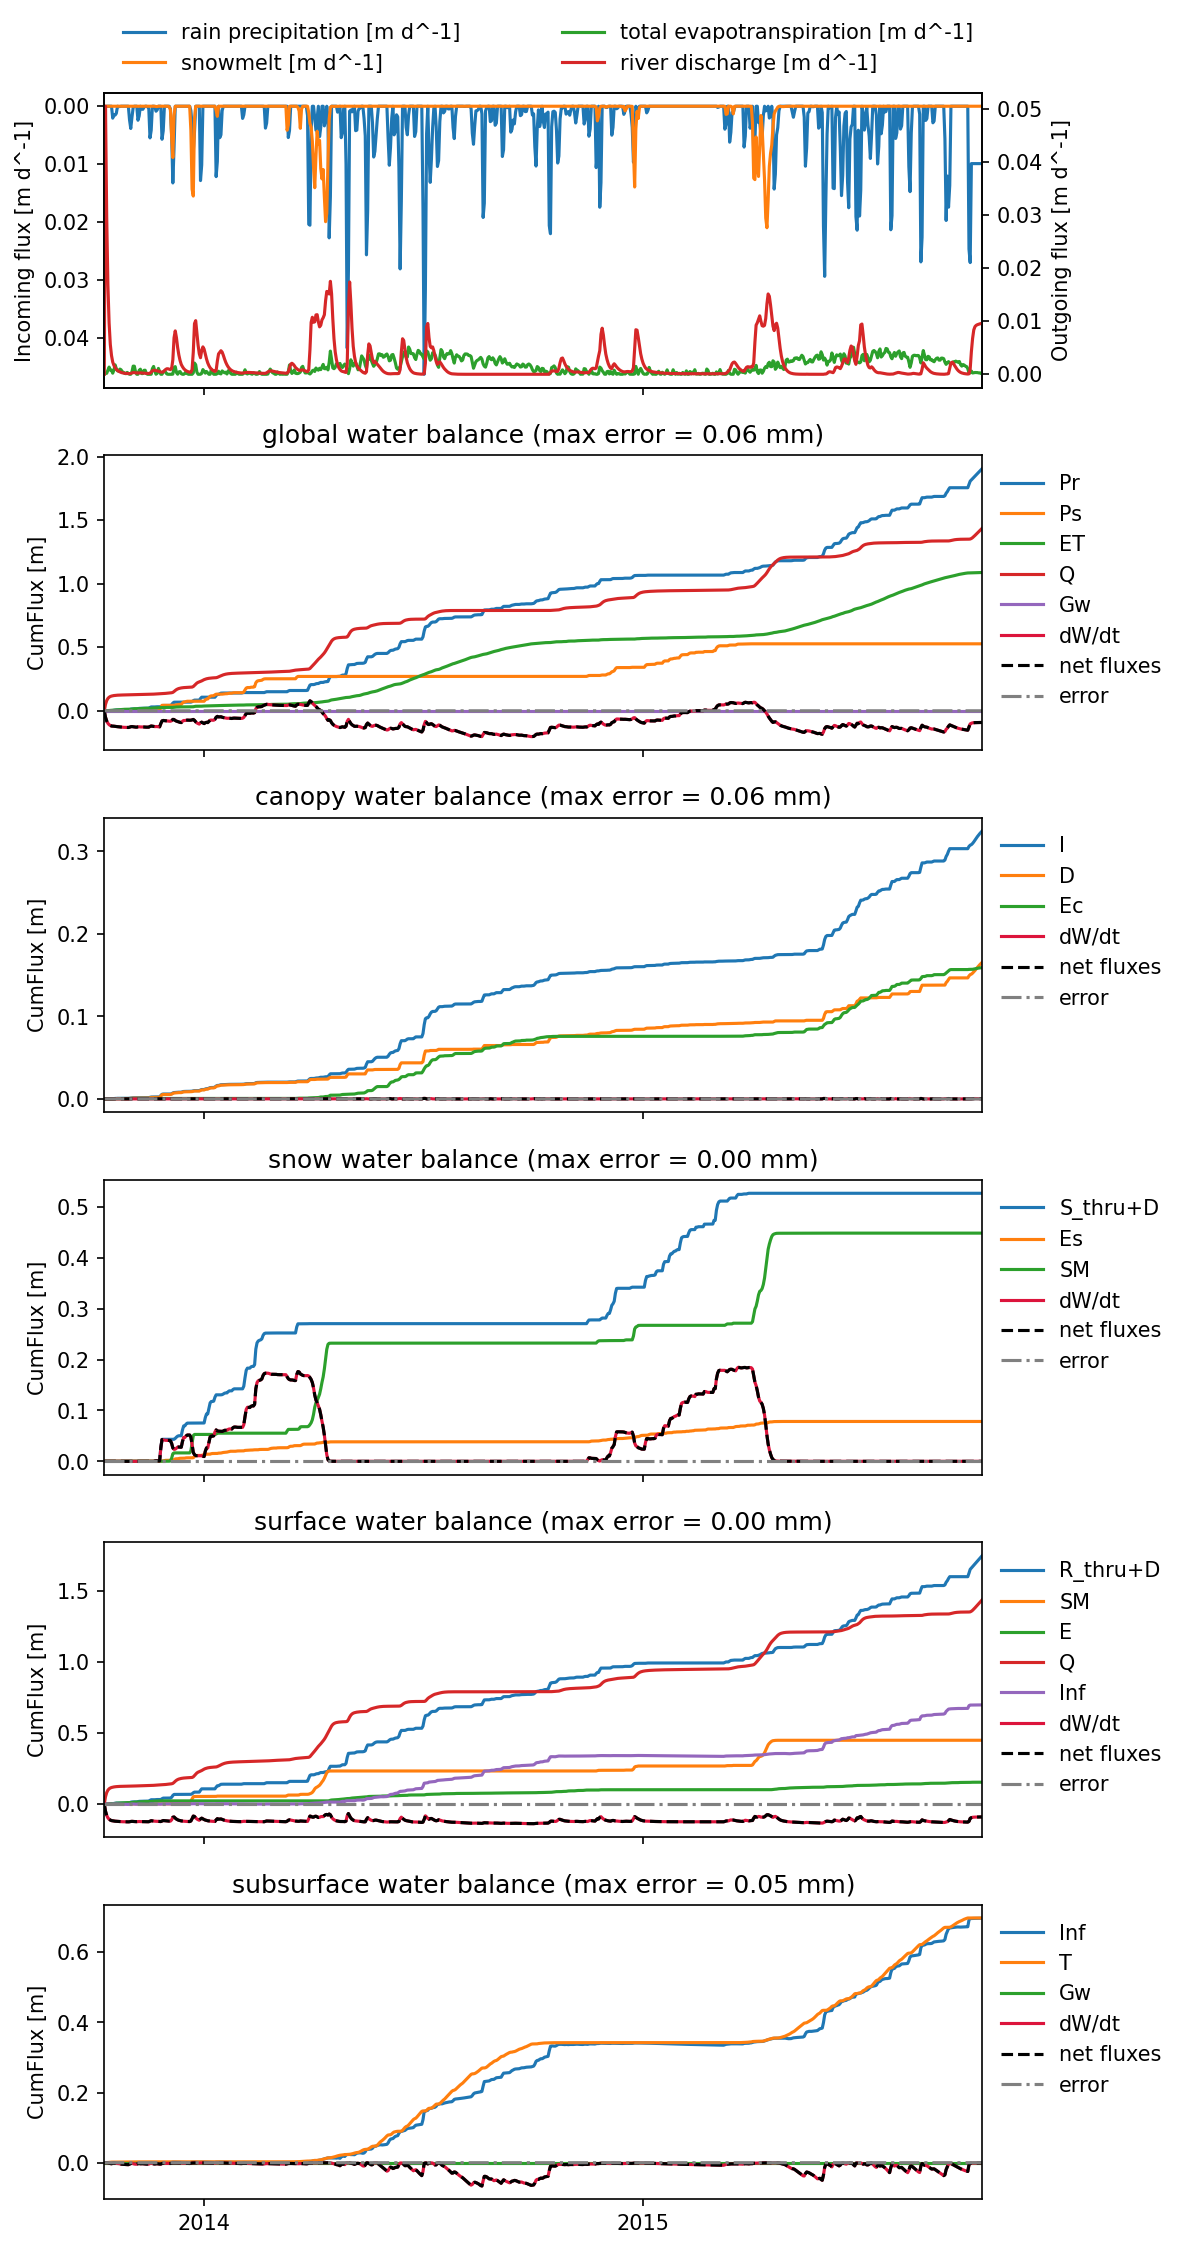

In [14]:
df = utils.load_waterBalance(model_dir, WB_filename="water_balance_computational_domain.csv",
                             domain_names = None,
                                canopy = True, plot = True
                               )

In [39]:
#df.head

In [40]:
modis_df=pd.read_csv("../../average_modis_et_timeseries.csv", index_col='time')
nhm_df=pd.read_csv("../../average_et_timeseries.csv", index_col='time')

nhm_df.index = pd.to_datetime(nhm_df.index.astype(str))
modis_df.index = pd.to_datetime(modis_df.index.astype(str))


In [41]:
# work_dir2 = f"../../../ats-project-v5/model2/"
# run_dir2 = "3-transient"
# model_dir2 = os.path.join(work_dir2, run_dir2)
# df2 = utils.load_waterBalance(model_dir, WB_filename="water_balance_computational_domain.csv",
#                              domain_names = None,
#                                 canopy = True, plot = True
#                                )

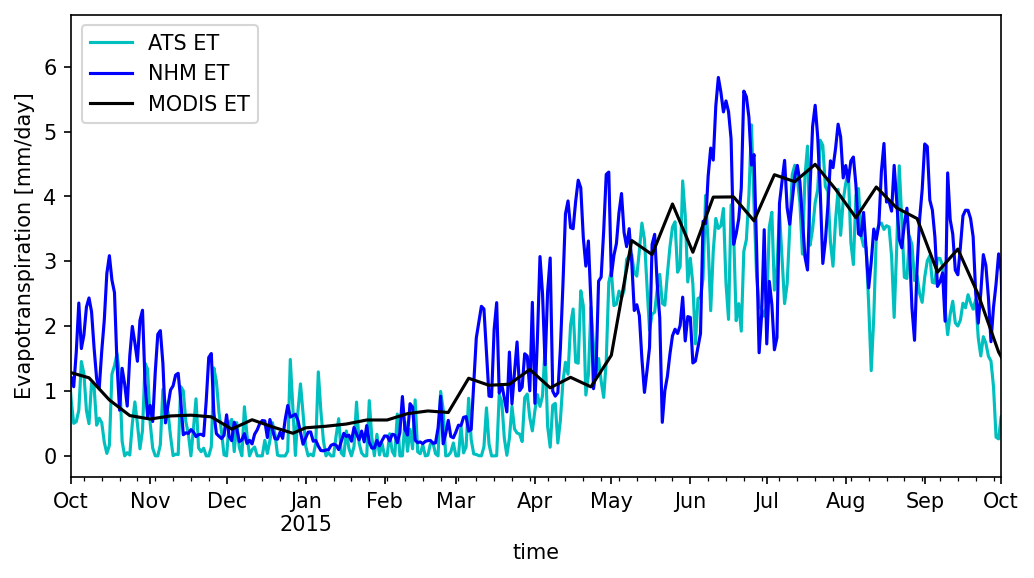

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# Plot full data
df['total evapotranspiration [mm d^-1]'].plot(color='c', ax=ax, label="ATS ET")
filtered_nhm_df = nhm_df.loc["2013-10-01":"2015-10-1"]
nhm_df['ET_mm'].plot(color='b', ax=ax, label="NHM ET")
modis_df['ET_mm_day'].plot(color='k', ax=ax, label="MODIS ET")

# Ensure m³/day is computed
#nhm_df['seg_outflow_m3'] = nhm_df['seg_outflow'] * 2446.58
#nhm_df['seg_outflow_m3'].plot(color='r', ax=ax, label="NHM_Q")

# Set axis limits
ax.set_xlim(pd.to_datetime("2014-10-01"), pd.to_datetime("2015-10-01"))
ax.set_ylabel("Evapotranspiration [mm/day]")
#ax.set_ylim(0, 3e6)
ax.legend()